## CARTPOLE PROBLEM

A pole is attached to a cart with an un-actuated joint. And your goal is to move the cart position, left and right, to prevent the pole from falling.

**<ins>Why this problem?</ins>**

So far in the course, we have used classical Reinforcement Learning algorithms, Q-learning (part 2), and SARSA (part 3) in a discrete/tabular environment.

Today’s problem is slightly more complex because its state space is *too large to be discretized*. Instead, we need to level up our game and use more powerful RL algorithms.

We will use `parametric Q-learning,` a technique that combines the classic Q-learning we saw in part 2, with parametric approximations, either linear ones (here in part 4) or a more complex one like neural nets (in part 5).

Parametric Q-learning using neural nets (aka Deep Q-learning) lies behind many recent breakthroughs in Reinforcement Learning, like the famous Atari game player by DeepMind.

Let’s get familiar with the specifics of this environment!

In [2]:
from matplotlib import pyplot as plt
import gym

# LOAD ENVIRONMENT
env = gym.make('CartPole-v1')

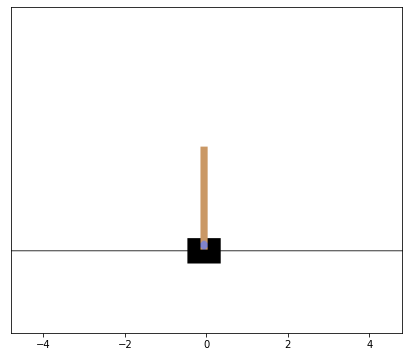

In [3]:
# SHOW A FRAME
env.reset()
frame = env.render(mode='rgb_array')

fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.yaxis.set_visible(False)
min_x = env.observation_space.low[0]
max_x = env.observation_space.high[0]
ax.imshow(frame, extent=[min_x, max_x, 0, 8])

#### ENVIRONMENT, ACTIONS, STATES, REWARDS

![](cartpole_image.jpeg)

### <ins>State</ins>

State is represented by 4 values shown above:

 - the cart position **x** from `-2.4` to `2.4`
 - the cart velocity **v**
 - the pole angle $\theta$ with respect to the vertical. From `-12` to `12` degrees (`-0.21` to `0.21` in radians)
 - the pole angular velocity $\omega$. This is the rate of change of $\theta$

In [7]:
# The state on observation space looks different though...
x_min, v_min, angle_min, angular_v_min = env.observation_space.low
x_max, v_max, angle_max, angular_v_max = env.observation_space.high

print(f'Cart position from {x_min:.2f} to {x_max:.2f}')
print(f'Cart velocity from {v_min:.2E} to {v_max:.2E}')
print(f'Angle from {angle_min:.2f} to {angle_max:.2f}')
print(f'Angular velocity from {angular_v_min:.2E} to {angular_v_max:.2E}')

Cart position from -4.80 to 4.80
Cart velocity from -3.40E+38 to 3.40E+38
Angle from -0.42 to 0.42
Angular velocity from -3.40E+38 to 3.40E+38


If you look at the OpenAI gym interval variables `env.observation_space.low` and `env.observation_space.high` you will see that these 2 numbers seem to be arbitrarily large or small and their intervals do NOT match what we have written above.

In practice, this is not true. Both **v** and $\omega$ have narrower intervals, but this is something you cannot directly read from the env object. You can only observe their real ranges as your agent explores the environment.

This is important because the models we will use today, and in part 5, work best with **normalized inputs**. In this case, **normalized states**. And to *normalize a number* you need to know first its max and min values. These 2 values for **v** and $\omega$ cannot be read from the env.observation_space . You need to estimate them using a bit of exploration.

<ins>DO NOT BLINDLY TAKE THE VALUES IN `env.observation_space` AS THE REAL RANGES FOR EACH STATE</ins>

### <ins>Episode starts and ends</ins>

An episode terminates when either:

 - the cart goes beyond the limits: `x > 2.4` or x `< -2.4`
 - the pole is too far from the vertical: `θ > 12` degrees or `θ < -12` degrees.
 - or we reached the maximum number of episodes steps, `500`. In this case, the agent perfectly solved the episode.

The starting state is sampled randomly from the interval `[-0.05, 0.05]` for each state. Sometimes, the starting position is so close to balance that the episode is easy. Other times, the starting position is so off-balance that the episode is much harder to solve, and sometimes even impossible.

### <ins>Actions</ins>

What about the **actions** our agent can perform?
 - 0 : Push the cart to the left.
 - 1 : Push the cart to the right.

### <ins>Rewards</ins>
The reward is `+1` for every step taken. This means that the longer the agent keeps the pole standing, the higher the cumulative reward.

### <ins>Random Agent Baseline</ins>

As usual, we use a `RandomAgent` to establish a baseline performance.

In [10]:
import numpy as np
from typing import Tuple, List, Callable, Union, Optional
import random
import numpy as np
from tqdm import tqdm

class RandomAgent:
    """
    This taxi driver selects actions randomly.
    You better not get into this taxi!
    """
    def __init__(self, env):
        self.env = env

    def act(self, state: np.array, epsilon: float = None) -> int:
        """
        No input arguments to this function.
        The agent does not consider the state of the environment when deciding
        what to do next.
        """
        return self.env.action_space.sample()

def evaluate(
    agent,
    env,
    n_episodes: int,
    epsilon: Optional[float] = None,
    seed: Optional[int] = 0,
) -> Tuple[List, List]:

    # output metrics
    reward_per_episode = []
    steps_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()
        rewards = 0
        steps = 0
        done = False
        while not done:

            action = agent.act(state, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)

            rewards += reward
            steps += 1
            state = next_state

        reward_per_episode.append(rewards)
        steps_per_episode.append(steps)

    return reward_per_episode, steps_per_episode

In [11]:
agent = RandomAgent(env)
n_episodes = 1000
rewards, steps = evaluate(agent, env, n_episodes)

100%|██████████| 1000/1000 [00:00<00:00, 1521.83it/s]


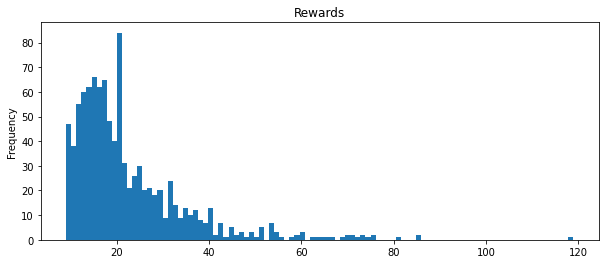

In [13]:
# SEE HOW FAR WE GOT
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

In [12]:
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 22.29, std 12.37


In [ ]:
# Bad hyper-parameters
hparams = {
    'learning_rate': 9.214691713730938e-05,
    'discount_factor': 0.99,
    'batch_size': 32,
    'memory_size': 10000,
    'freq_steps_train': 16,
    'freq_steps_update_target': 1000,
    'n_steps_warm_up_memory': 1000,
    'n_gradient_steps': 1,
    'max_grad_norm': 1,
    'normalize_state': True,
    'epsilon_start': 0.9,
    'epsilon_end': 0.08474621504763855,
    'steps_epsilon_decay': 100000
}